In [1]:
import yaml
import os
from towbintools.foundation import file_handling as file_handling
import pandas as pd
import shutil

import numpy as np
import argparse
import matplotlib.pyplot as plt

from scipy import interpolate
import seaborn as sns
import starbars
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu

from scipy.signal import savgol_filter, medfilt
from towbintools.foundation.utils import interpolate_nans

from plotting_functions import combine_experiments
from plotting_functions import plot_aggregated_series, plot_correlation, plot_correlation_at_ecdysis, boxplot_at_molt, plot_growth_curves_individuals, plot_deviation_from_model_at_ecdysis, plot_normalized_proportions, plot_deviation_from_model, get_most_average_deviations_at_ecdysis, get_most_average_proportions_at_ecdysis, get_most_average_size_at_ecdysis, plot_developmental_success, plot_arrests

# make warnings happen only once
import warnings
warnings.filterwarnings("once")


In [2]:
filemap_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis/report/analysis_filemap.csv",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis/report/analysis_filemap.csv",
]

conditions_paths = [
    "/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/doc/conditions.yaml",
    "/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/doc/conditions.yaml",
]

organ_channels = [{'body': 2, 'pharynx' : 1}]

backup_path = "/mnt/towbin.data/shared/spsalmon/plotting_backups/yap1_deletion/"
filemap_backup_path = os.path.join(backup_path, "filemaps")
conditions_backup_path = os.path.join(backup_path, "conditions")
structure_backup_path = os.path.join(backup_path, "structure")

os.makedirs(backup_path, exist_ok=True)
os.makedirs(filemap_backup_path, exist_ok=True)
os.makedirs(conditions_backup_path, exist_ok=True)
os.makedirs(structure_backup_path, exist_ok=True)

for i, (filemap_path, config_path) in enumerate(zip(filemap_paths, conditions_paths)):
    output_name = f"analysis_filemap_{i}.csv"
    output_name_config = f"config_{i}.yaml"
    
    # Copy the filemap to the backup path
    shutil.copy(filemap_path, os.path.join(filemap_backup_path, output_name))
    shutil.copy(config_path, os.path.join(conditions_backup_path, output_name_config))

# Copy the current working directory to the backup path
current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)
destination = os.path.join(backup_path, current_dir_name)

shutil.copytree(current_dir, destination, dirs_exist_ok=True)

print("Backup completed successfully!")

Backup completed successfully!


In [3]:
import pickle
conditions_struct = combine_experiments(filemap_paths, conditions_paths, organ_channels=organ_channels)

# backup the conditions struct
with open(os.path.join(structure_backup_path, "plotting_struct.pkl"), "wb") as f:
    pickle.dump(conditions_struct, f)

Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returning original series.
Error in interpolation, returni

In [4]:
for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}")

Condition: (0, {'WT yap-1, no TIR'})
Condition: (1, {'WT yap-1, col-10:TIR'})
Condition: (2, {'yap-1 (tm1416), no TIR'})
Condition: (3, {'yap-1 (tm1416), col-10:TIR'})
Condition: (4, {'yap-1 (abt7), no TIR'})
Condition: (5, {'yap-1 (abt7), col-10:TIR'})


In [5]:
# idx = 0
# for point, experiment in zip(conditions_struct[idx]['point'], conditions_struct[idx]['experiment']):
#     print(f"Point: {point}, Experiment: {experiment}")

In [6]:
# # order conditions by auxin concentration
# conditions_struct = sorted(conditions_struct, key=lambda x: x["auxin_concentration"])
# # reassign the condition ids
# for i, condition in enumerate(conditions_struct):
#     condition["condition_id"] = i

# for condition in conditions_struct:
#     print(f"Condition: {condition['condition_id'], {condition['description']}}")

In [7]:
print(conditions_struct[0].keys())

dict_keys(['strain', 'description', 'condition_id', 'ecdysis_time_step', 'larval_stage_durations_time_step', 'ecdysis_experiment_time', 'larval_stage_durations_experiment_time', 'experiment', 'point', 'body_seg_str_volume', 'body_seg_str_length', 'body_seg_str_worm_type', 'body_seg_str_volume_at_ecdysis', 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_volume', 'pharynx_seg_str_length', 'pharynx_seg_str_worm_type', 'pharynx_seg_str_volume_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', 'time', 'experiment_time'])


In [8]:
# change figure size to your liking
plt.rcParams['figure.figsize'] = [12, 10]

# make lines thicker
plt.rcParams['lines.linewidth'] = 2

# make font size bigger
plt.rcParams.update({'font.size': 12})

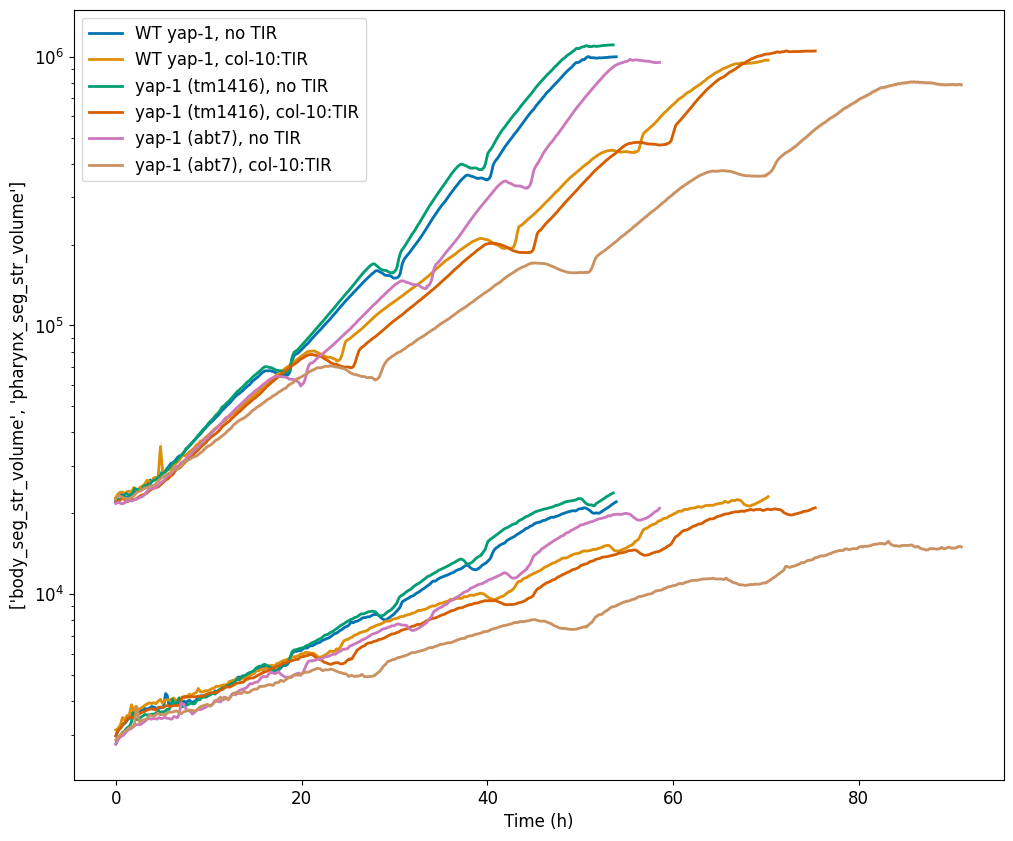

In [9]:
conditions_to_plot = [0, 1, 2, 3, 4, 5]
colors = None

plot_aggregated_series(conditions_struct, ['body_seg_str_volume', 'pharynx_seg_str_volume'], conditions_to_plot, colors=colors, experiment_time = False, aggregation='mean', n_points=100, time_step = 14, log_scale = True, legend = {'description': ''})

In [10]:
# conditions_to_plot = [0, 1, 3, 5, 7]
# colors = ['blue']
# colors += sns.color_palette("Blues", len(conditions_to_plot) - 1)

# plot_correlation(conditions_struct, 'body_seg_str_length', 'body_seg_str_volume', conditions_to_plot, log_scale = (False, True), legend = {'description': ''}, colors = colors)

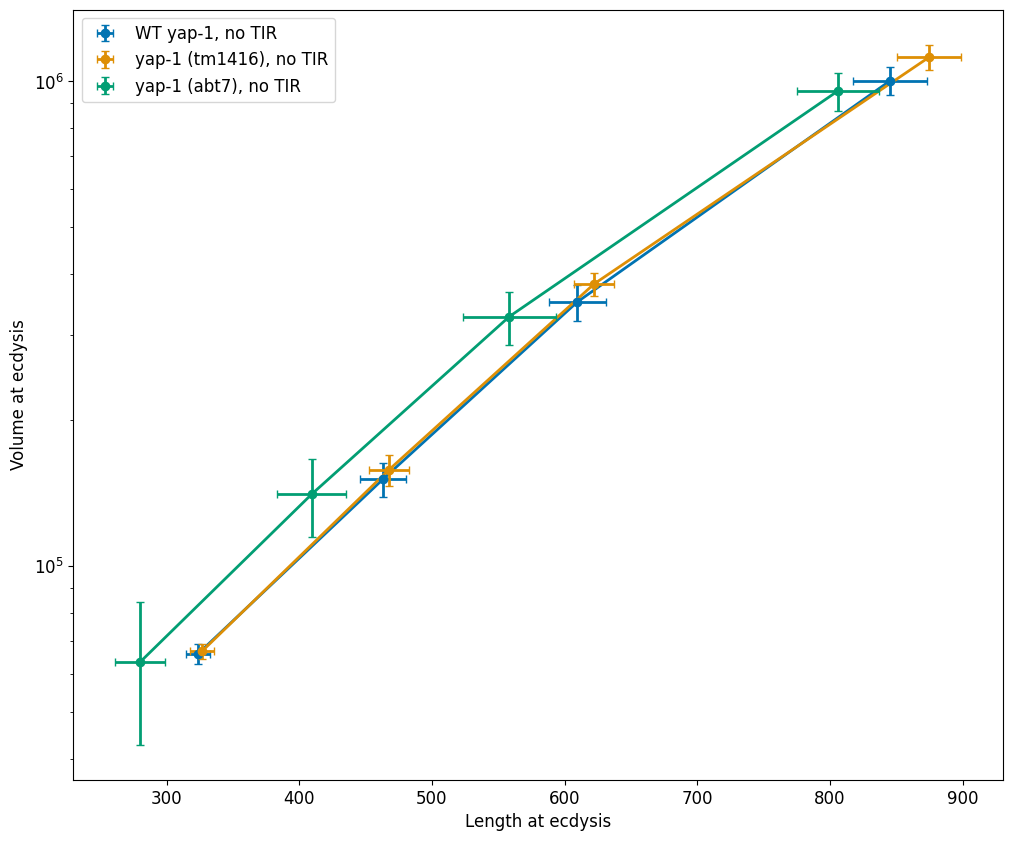

In [11]:
conditions_to_plot = [0, 2, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_volume_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (False, True), legend = {'description': ''}, y_axis_label='Volume at ecdysis', x_axis_label='Length at ecdysis')

In [12]:
# boxplot_at_molt(conditions_struct, 'larval_stage_durations_time_step', [0, 1, 2, 3], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Larval stage duration (time step)", titles = ['L1', 'L2', 'L3', 'L4'])

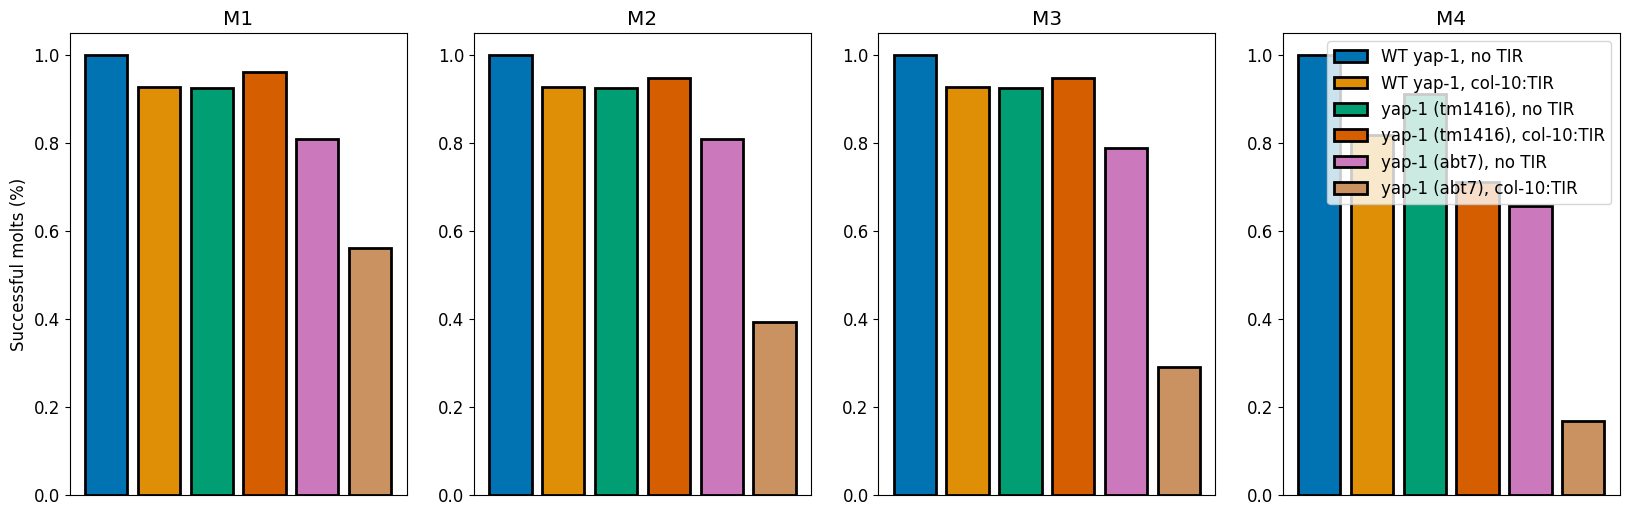

In [13]:
plot_developmental_success(conditions_struct, [0, 1, 2, 3, 4, 5], legend = {'description': ''})

0 0 0 0
58 58 58 58
4 0 0 6
55 51 55 55
6 0 0 1
79 73 79 79
3 1 0 18
76 73 75 76
19 0 2 13
99 80 99 97
68 26 17 19
155 87 129 138


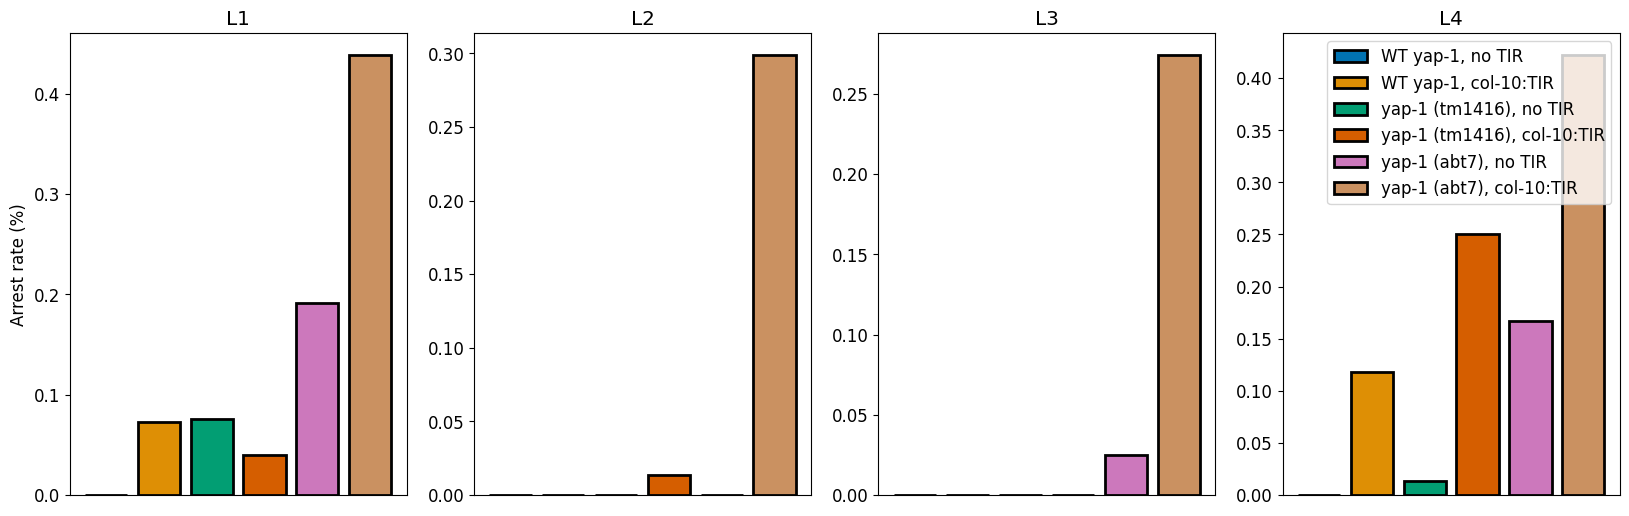

In [14]:
plot_arrests(conditions_struct, [0, 1, 2, 3, 4, 5], legend = {'description': ''})

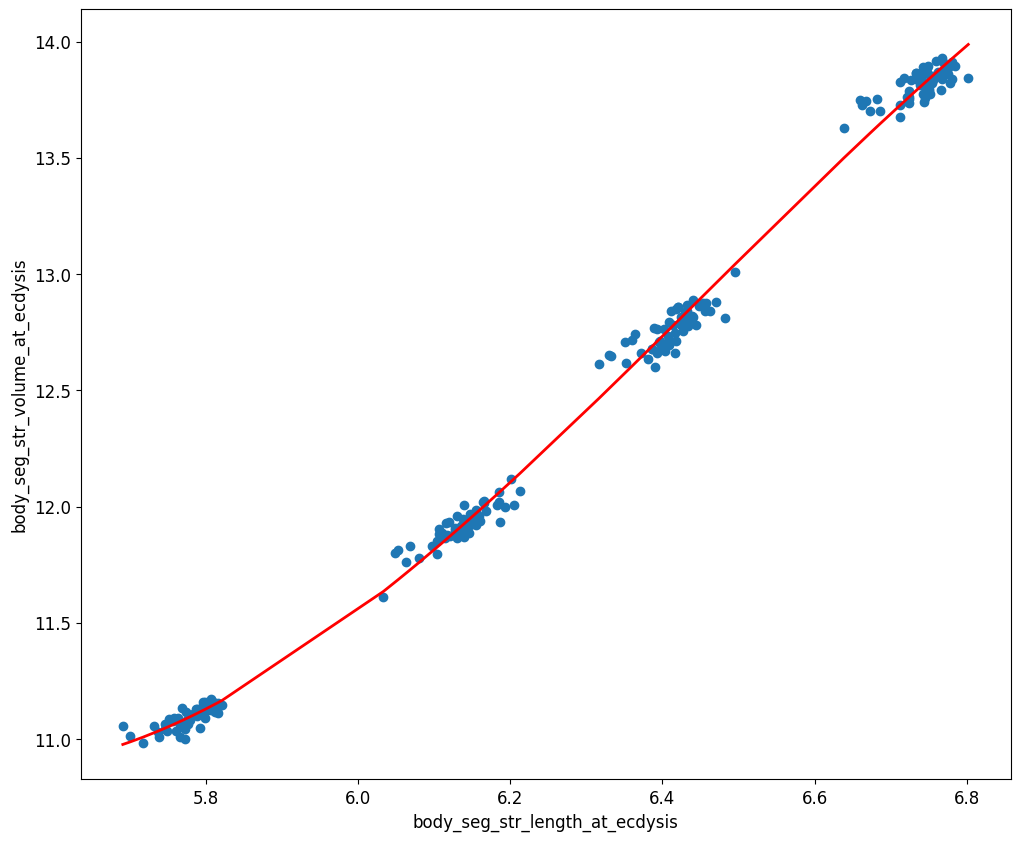

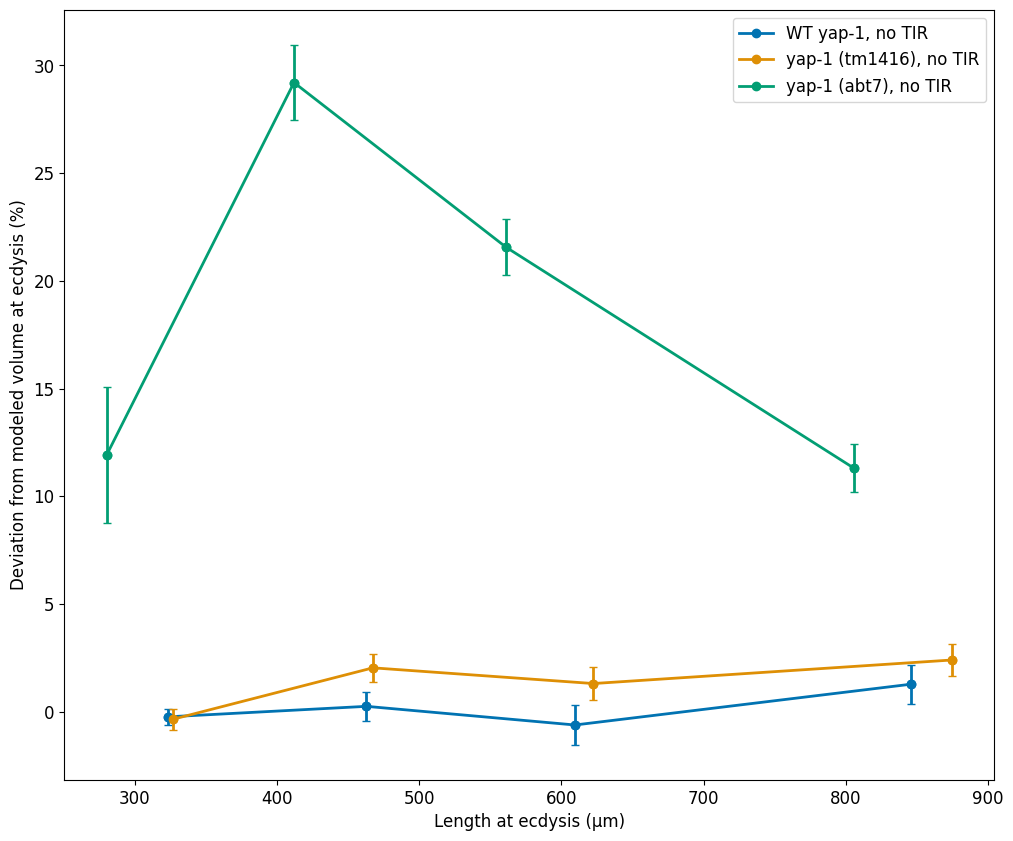

In [29]:
conditions_to_plot = [0, 2, 4]
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "body_seg_str_volume_at_ecdysis", 0, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled volume at ecdysis (%)')

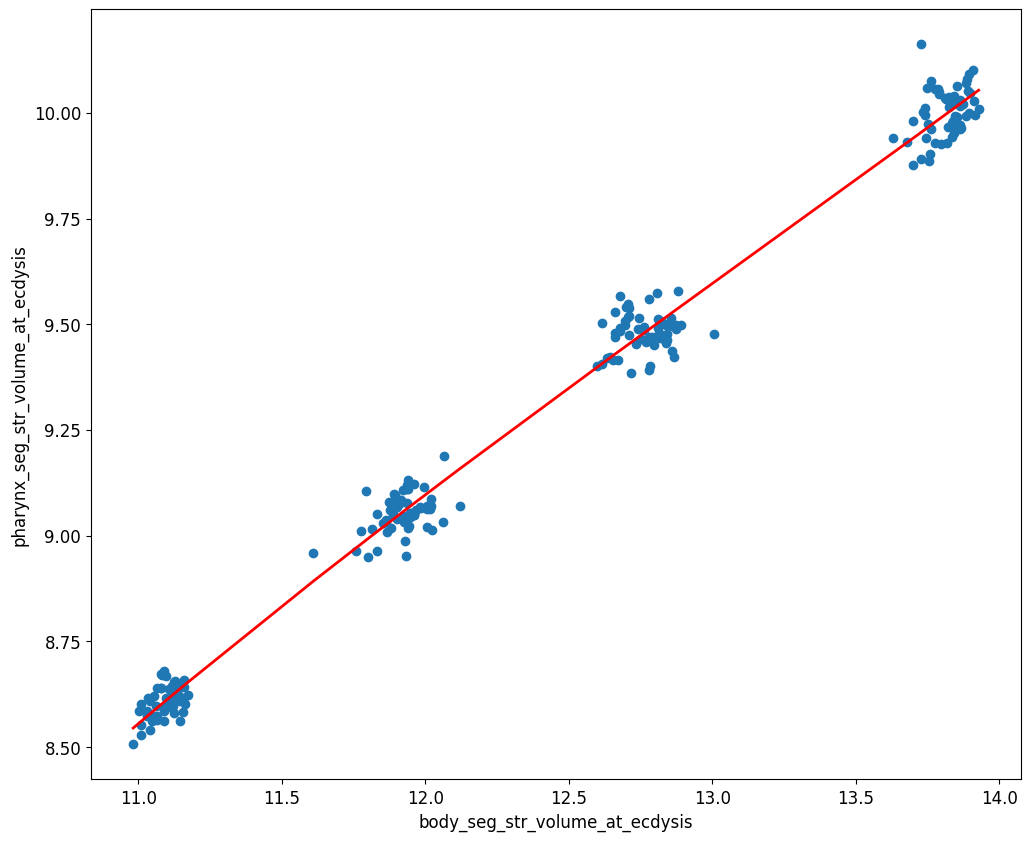

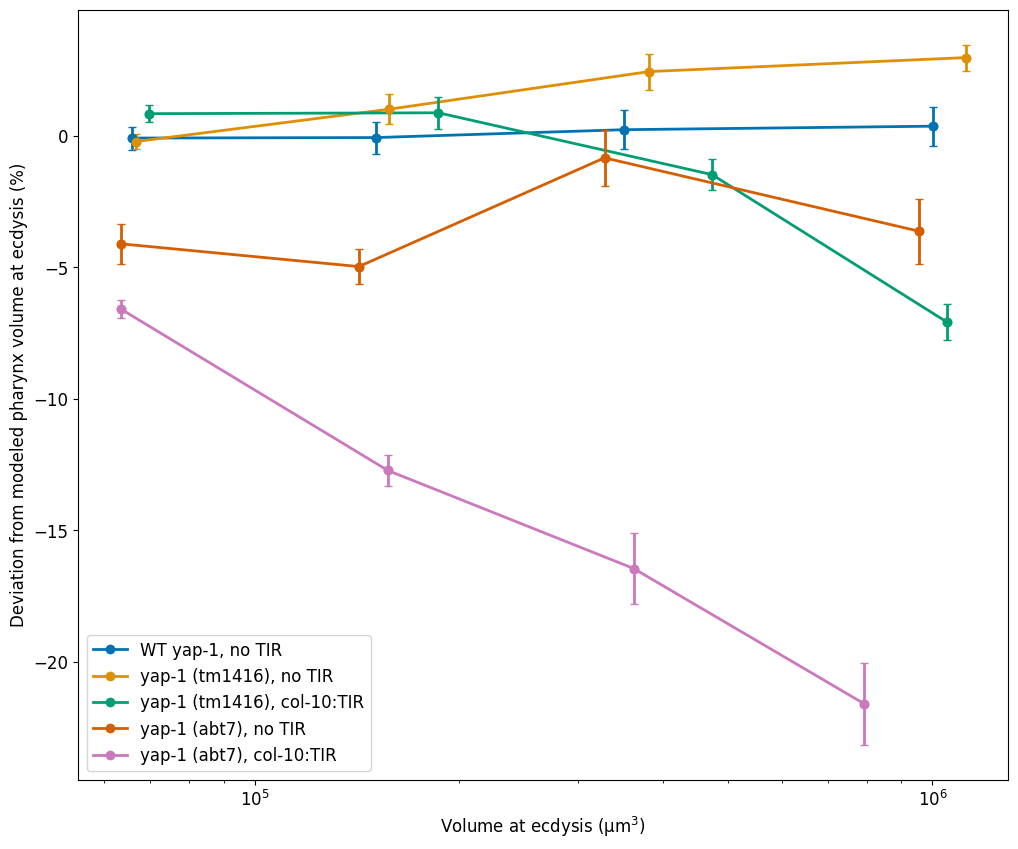

In [30]:
conditions_to_plot = [0, 2, 3, 4, 5]
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_volume_at_ecdysis", "pharynx_seg_str_volume_at_ecdysis", 0, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Volume at ecdysis (µm$^3$)', y_axis_label='Deviation from modeled pharynx volume at ecdysis (%)')

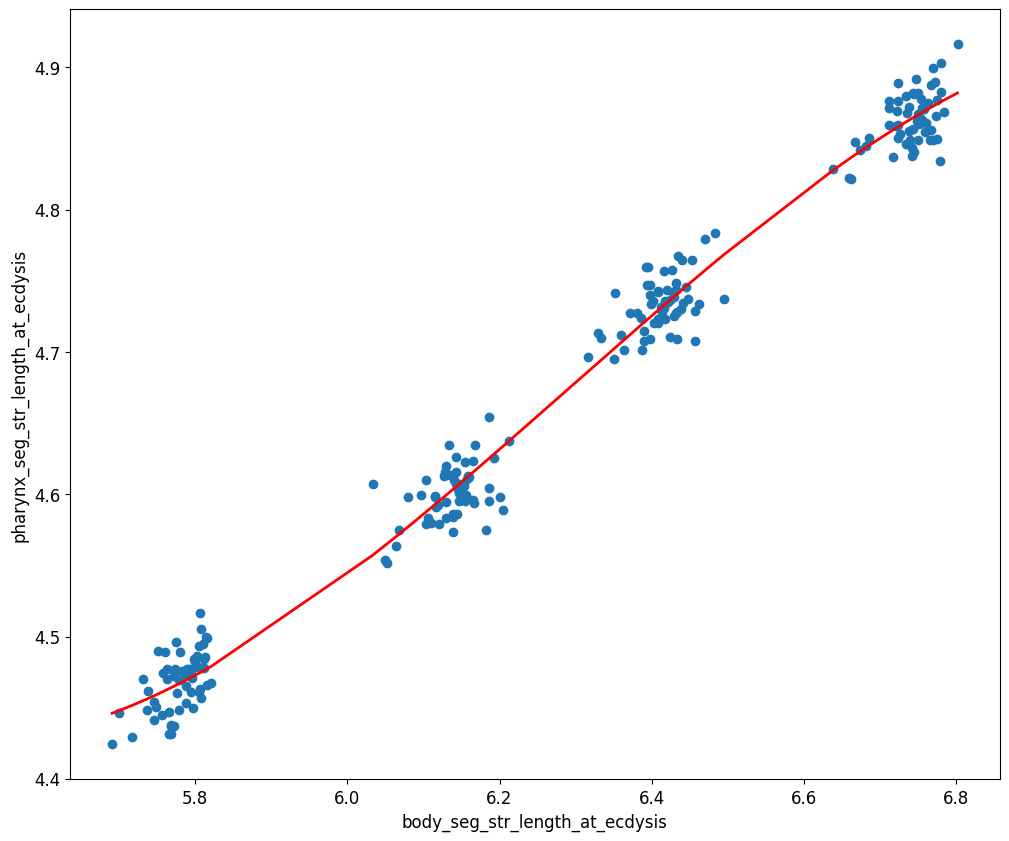

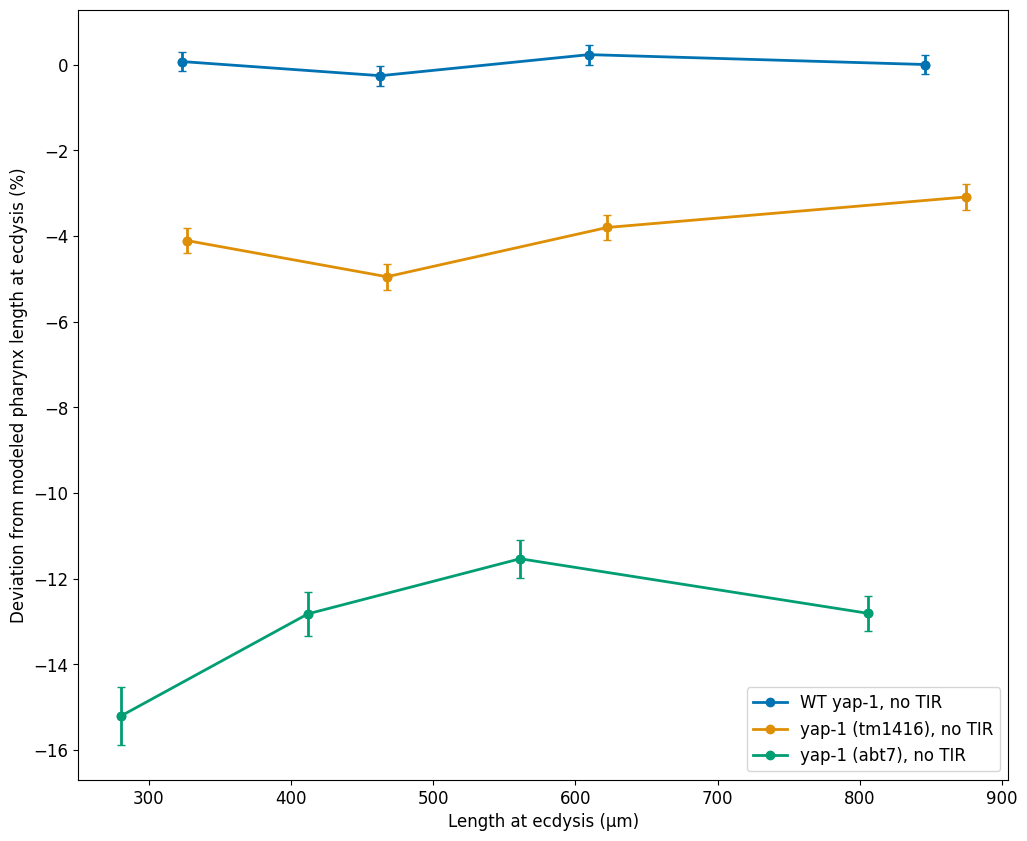

In [31]:
conditions_to_plot = [0, 2, 4]
colors = None


plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "pharynx_seg_str_length_at_ecdysis", 0, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (False, False), legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx length at ecdysis (%)')

In [32]:
get_most_average_size_at_ecdysis(
    conditions_struct,
    'body_seg_str_volume_at_ecdysis',
    ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
    [0],
    remove_hatch=False,
    exclude_arrests=True,
    dpi=600,
    nb_per_condition=2,
    cmap=['pure_red', 'pure_green'],
)

KeyboardInterrupt: 

(2, 141, 261)
(2, 141, 272)
(2, 141, 435)
(2, 141, 436)
(2, 141, 647)
(2, 141, 654)
(2, 141, 843)
(2, 141, 868)
(2, 141, 1240)
(2, 141, 1278)


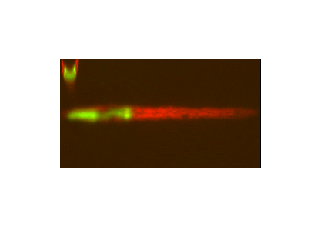

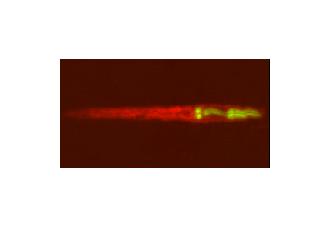

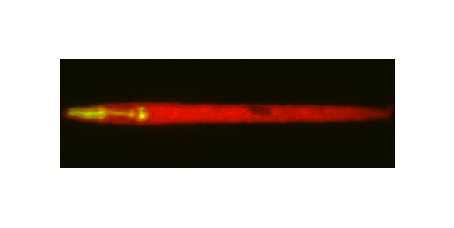

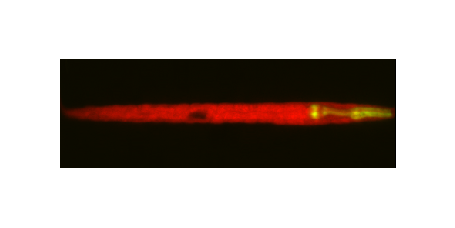

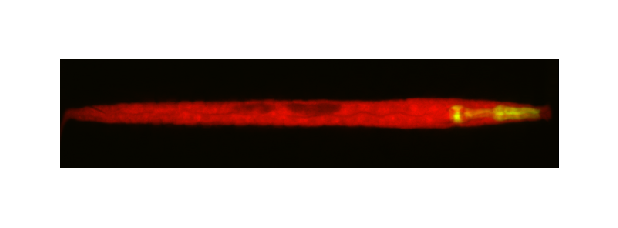

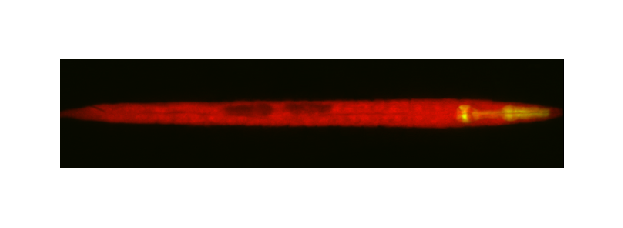

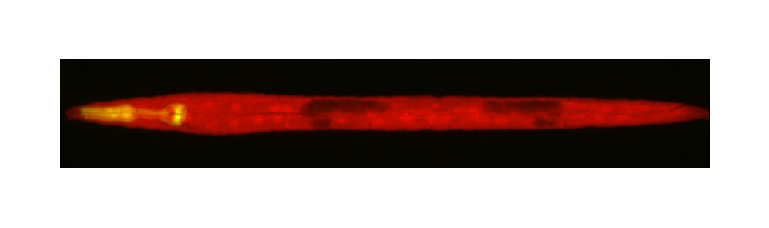

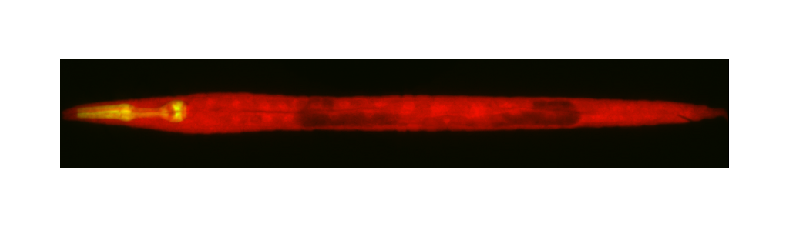

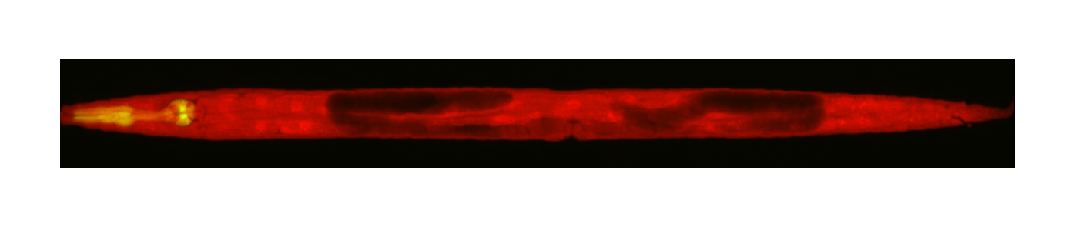

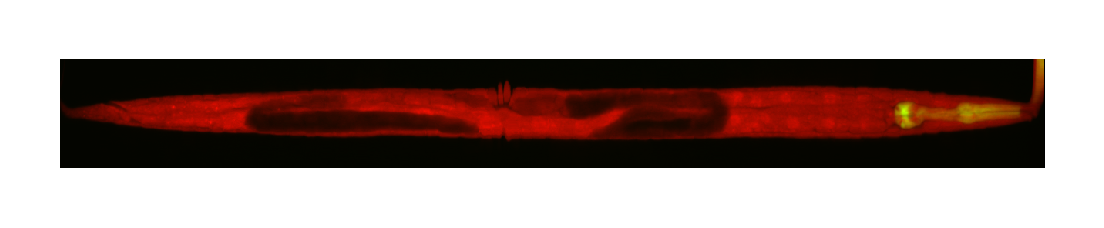

In [ ]:
get_most_average_size_at_ecdysis(
    conditions_struct,
    'body_seg_str_volume_at_ecdysis',
    ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
    [4],
    remove_hatch=False,
    exclude_arrests=True,
    dpi=600,
    nb_per_condition=2,
    cmap=['pure_red', 'pure_green'],
)

In [ ]:
get_most_average_proportions_at_ecdysis(
    conditions_struct,
    'body_seg_str_length_at_ecdysis',
    'body_seg_str_volume_at_ecdysis',
    ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
    [0],
    remove_hatch=False,
    exclude_arrests=True,
    dpi=600,
    nb_per_condition=2,
    cmap=['pure_red', 'pure_green'],
)

KeyboardInterrupt: 

(2, 141, 262)
(2, 141, 269)
(2, 141, 379)
(2, 141, 392)
(2, 141, 585)
(2, 141, 556)
(2, 141, 774)
(2, 141, 773)
(2, 141, 975)
(2, 141, 1002)


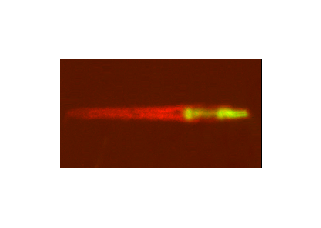

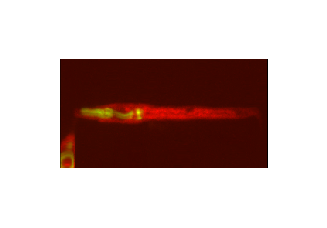

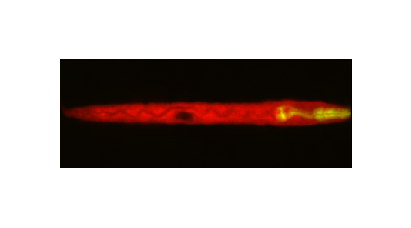

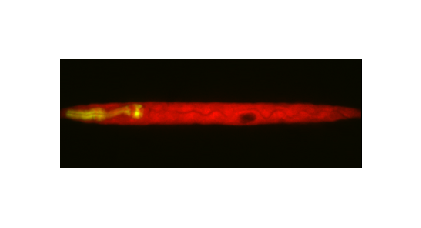

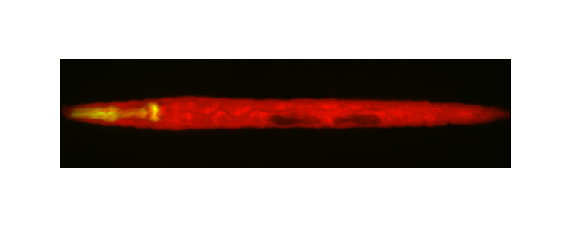

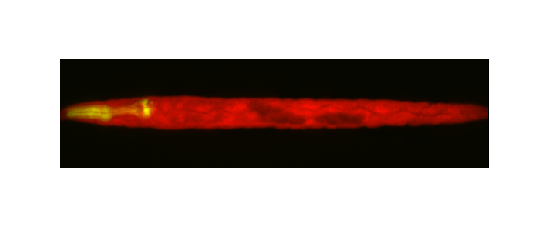

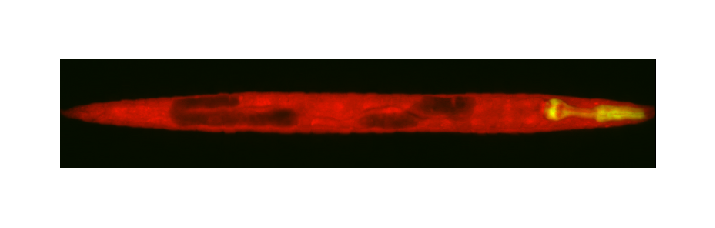

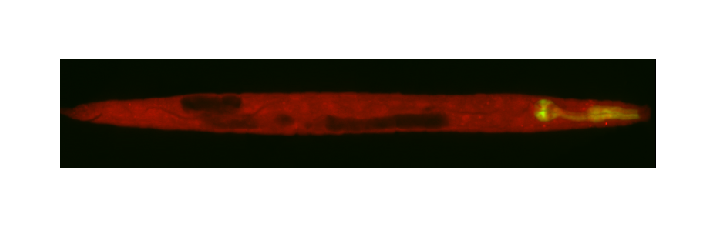

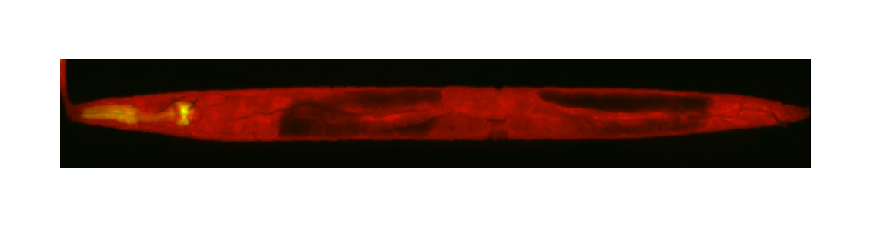

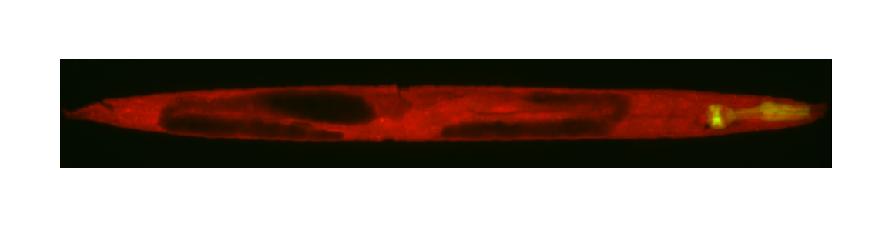

In [ ]:
get_most_average_proportions_at_ecdysis(
    conditions_struct,
    'body_seg_str_length_at_ecdysis',
    'body_seg_str_volume_at_ecdysis',
    ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
    [5],
    remove_hatch=False,
    exclude_arrests=True,
    dpi=600,
    nb_per_condition=2,
    cmap=['pure_red', 'pure_green'],
)

In [ ]:
# def plot_heterogeneity_at_ecdysis(conditions_struct, column, conditions_to_plot, remove_hatch = True, legend = None, x_axis_label = None, y_axis_label = None, keep_only_complete_development = False):
#     for condition in conditions_to_plot:
#         condition_dict = conditions_struct[condition]

#         values = condition_dict[column]

#         base_shape = values.shape[0]

#         if remove_hatch:
#             values = values[:, 1:]

#         if keep_only_complete_development:
#             values = values[~np.isnan(values).any(axis=1)]
#             print(f"Removed {base_shape - values.shape[0]} worms that did not complete development")


#         cvs = []
#         for i in range(values.shape[1]):
#             values_at_ecdysis = values[:, i]
#             cv = np.nanstd(values_at_ecdysis) / np.nanmean(values_at_ecdysis)
#             cvs.append(cv)

#         plt.plot(cvs, label = condition_dict['description'], marker = 'o')
#     plt.show()

# plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', [3, 2, 6, 10], legend = {'strain': ''}, keep_only_complete_development = True)   
# plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', [3, 2, 6, 10], legend = {'strain': ''}, keep_only_complete_development = True)